# Assignment 4 - CNN - FashionMnist


In [2]:
# install packages
!pip install torchvision
!pip install mnist_reader
!pip install torchsummary

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/a8/95/affe174621ebc9b32544a918ae6cb758ac06061d0ee51d783e06906ceba1/torchvision-0.17.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torch==2.2.1 from https://files.pythonhosted.org/packages/3e/b9/256ab23c859cbcd7d6fb7cb46417a07eac817881a0a68df8ea0c18f45221/torch-2.2.1-cp311-none-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 15.3 MB/s eta 0:00:0000:0100:01
ERROR: Could not find a version that satisfies the requirement mnist_reader (from versions: none)
ERROR: No matching distribution found for mnist_reader
  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [116]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image
import torch.nn.functional as F

In [117]:
# set seed for reproducibility
torch.manual_seed(12) # voor torch
random.seed(12) # for other py functions


## Get new data

In [132]:
import pandas as pd 
df = pd.read_csv('archive/styles.csv', on_bad_lines='skip')


def item_to_label(item):
    labels_map = {
        'T-Shirt': ["Tshirts"],
        'Trouser': ["Jeans", "Track Pants", "Trousers"],
        'Pullover': ["Sweatshirts", "Sweaters"],
        'Dress': ["Dresses"],
        'Coat': ["Jackets", "Blazers", "Coats"],
        'Sandal': ["Sandals", "Sports Sandals", "Flip Flops"],
        'Shirt': ["Shirts"],
        'Sneaker': ["Casual Shoes", "Sports Shoes"],
        'Bag': ["Handbags", "Backpacks", "Laptop Bag", "Duffel Bag", "Messenger Bag", "Trolley Bag"],
        'Ankle boot': ["Boots", "Booties"]  
    }
    
    for label, items in labels_map.items():
        if item in items:
            return label

    return None

# Apply the mapping function to your DataFrame
df['MappedLabel'] = df['subCategory'].apply(item_to_label)
df['MappedLabel'] = df['articleType'].apply(item_to_label)

# Now filter out rows that don't have a matching label
df_filtered = df[df['MappedLabel'].notnull()]


df_newdata = df_filtered[['id', 'MappedLabel']]

In [119]:
# Apply the mapping function to both 'subCategory' and 'articleType' and ensure that
# if 'subCategory' mapping is None, 'articleType' mapping is used
df['MappedLabel'] = df.apply(lambda x: item_to_label(x['subCategory']) if item_to_label(x['subCategory']) is not None else item_to_label(x['articleType']), axis=1)

# Now filter out rows that don't have a matching label
df_filtered = df[df['MappedLabel'].notnull()]


In [120]:
import os
images_folder_path = 'archive/images'

# Initialize lists to store the flattened images and labels
flattened_images = []
labels = []

for _, row in df_filtered.iterrows(): # df veranderen in df_newdata
    image_path = os.path.join(images_folder_path, f"{row['id']}.jpg")
    try:
        with Image.open(image_path) as img:
            # Convert to grayscale
            img = img.convert('L')
            # Resize to 28x28
            img = img.resize((28, 28))
            # Convert image data to a numpy array and flatten it
            flattened_img = np.array(img).flatten()
            # Append the flattened image and the label to the lists
            flattened_images.append(flattened_img)
            labels.append(row['MappedLabel'])
    except FileNotFoundError:
            print(f"File {image_path} not found, skipping.")
            continue 

File archive/images/39403.jpg not found, skipping.
File archive/images/39410.jpg not found, skipping.
File archive/images/39401.jpg not found, skipping.
File archive/images/39425.jpg not found, skipping.


In [121]:
clean_labels = []
clean_images = []
for i in range(len(labels)): 
    if labels[i] != None:
        # print("none instance found, removing")
        clean_labels.append(labels[i])
        clean_images.append(flattened_images[i])
        
# Convert lists to NumPy arrays
flattened_images_np = np.array(clean_images)
labels_np = np.array(clean_labels)

print(len(labels_np))
print(len(flattened_images_np))

22486
22486


## Visualize image to make sure the numpy images are loaded correctly 

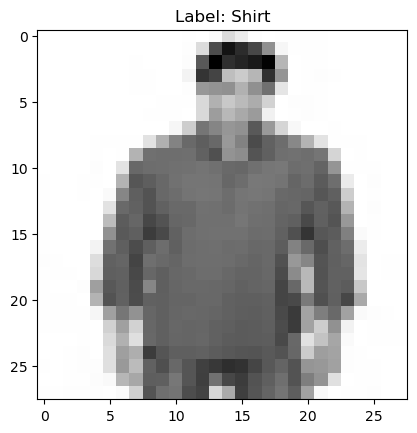

In [134]:
first_image = flattened_images_np[5].reshape(28, 28)

# Plotting
plt.imshow(first_image, cmap='gray')  # 'gray' colormap for grayscale
plt.title(f"Label: {labels_np[5]}")
plt.show()

## Custom Dataloader

In [158]:
from torchvision.transforms import ToTensor, Normalize, Compose
# inverted labels map needed to encode labels in dataloader 
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
inv_labels_map = {v: k for k, v in labels_map.items()}

class CustomFashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        assert len(images) == len(labels), "Images and labels must be of the same length"
        self.images = images
        self.labels = labels
        self.transform = transform
        self.inv_labels_map = {v: k for k, v in labels_map.items()}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = flattened_images_np[idx].reshape(28, 28)  # Assume images are grayscale
        img = to_pil_image(img)
        label_str = self.labels[idx]
        label = self.inv_labels_map[label_str]  # Convert string label to its numeric value

        
        if self.transform:
            img = self.transform(img)
        else:
            # If no transform specified, convert to tensor as expected by PyTorch models
            img = to_tensor(img)
        
        label_str = self.labels[idx]
        label = self.inv_labels_map[label_str]  # Convert string label to its numeric value
        label = torch.tensor(label, dtype=torch.long)

        return img, label

transform = Compose([
    transforms.RandomHorizontalFlip(), # added flip improves acc
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Assuming grayscale images
])

dataset_newdata = CustomFashionMNISTDataset(flattened_images_np, labels_np, transform=transform)
dataloader_newdata = DataLoader(dataset_newdata, batch_size=64, shuffle=True, num_workers=0)

print('done')

done


## LeNet5_Dropout #

In [159]:
class LeNet5_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer: using a smaller kernel size (3x3) to capture finer details.
        # Adjusted padding to 1 to maintain output size of 28x28x6.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), # add batchNorm, 32 features
            nn.ReLU())

        # Average pool layer / subsampling,
        # output size remains 14x14x6.
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second convolutional layer, using 3x3 kernels , 16 filters
        # Adjusted padding to maintain the intended output size dimensions. >> kan niet? Dan moet padding -1 zijn?
        # output size NEW: 12x12x16 (was 10x10x16 met kernel size 5 en padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32), # add batchNorm, 32 features
            nn.ReLU())

        # Adjusting the average pooling to accommodate changes in feature map size,
        # output size: 6x6x16. (BERBER): is het erg dat dit even is? Eeerst was het 5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # fully connected layer 1: output 120 feature maps
        # new input (want aangepast): dus input 6x6x120
        # output = 120 feeature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=6*6*32, out_features=120),
            nn.ReLU(),
            nn.Dropout(0.25)) # add dropout

        # Fully connected layer 2
        # output = 84 features
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.25)) # add dropout

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, return_embedding=False):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        if return_embedding:
            return out
        out = self.ful_conn3(out)
        return out


## Define some functions 

In [160]:
def train(dataloader, model, loss_func, optimizer):
    # set to train mode
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # prediction and loss > forqard pass
        pred = model(X)
        loss = loss_func(pred, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    return train_loss, 100 * correct


def val(dataloader, model, loss_func):
    # set to evaluate instead of train
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_func(pred, y).item() #get loss over validation set
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    return val_loss, 100 * correct

def test(dataloader, model, loss_func):
    # set to evaluate instead of train
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_func(pred, y).item() #get loss over validation set
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    return val_loss, 100 * correct

#adjusted this bc wasn't working with seaborn
def generate_confusion_matrix(model, dataloader, labels_map):
    model.eval()

    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
        for X, y in dataloader:
            preds = model(X)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, y), dim=0)

    predicted_labels = all_preds.argmax(dim=1)
    cm = confusion_matrix(all_labels.numpy(), predicted_labels.numpy())

    #  plot the matrix with matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))  # Use ax for the axes
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    cbar = plt.colorbar(im)  # Store the colorbar in a variable
    
    # Remove the colorbar's border
    cbar.outline.set_visible(False)

    # Remove the plot's border
    for spine in ax.spines.values():
        spine.set_visible(False)

    tick_marks = np.arange(len(labels_map.values()))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels_map.values(), rotation=0)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels_map.values(), rotation=90)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    # Annotate each cell with the numeric value using plt.text()
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()

    return cm

## Run the new data through model 

In [161]:
model_dropout = LeNet5_Dropout()
# Load the saved state dict into the model
model_dropout.load_state_dict(torch.load('model_weights_Dropout.pth'))
# Ensure to call eval() for inference to set dropout and batch normalization layers to evaluation mode
model_dropout.eval()

loss_func = nn.CrossEntropyLoss() # cross entropy loss

loss, accuracy = test(dataloader_newdata, model_dropout, loss_func)
print(accuracy)

25.758249577514896


## visualize results 

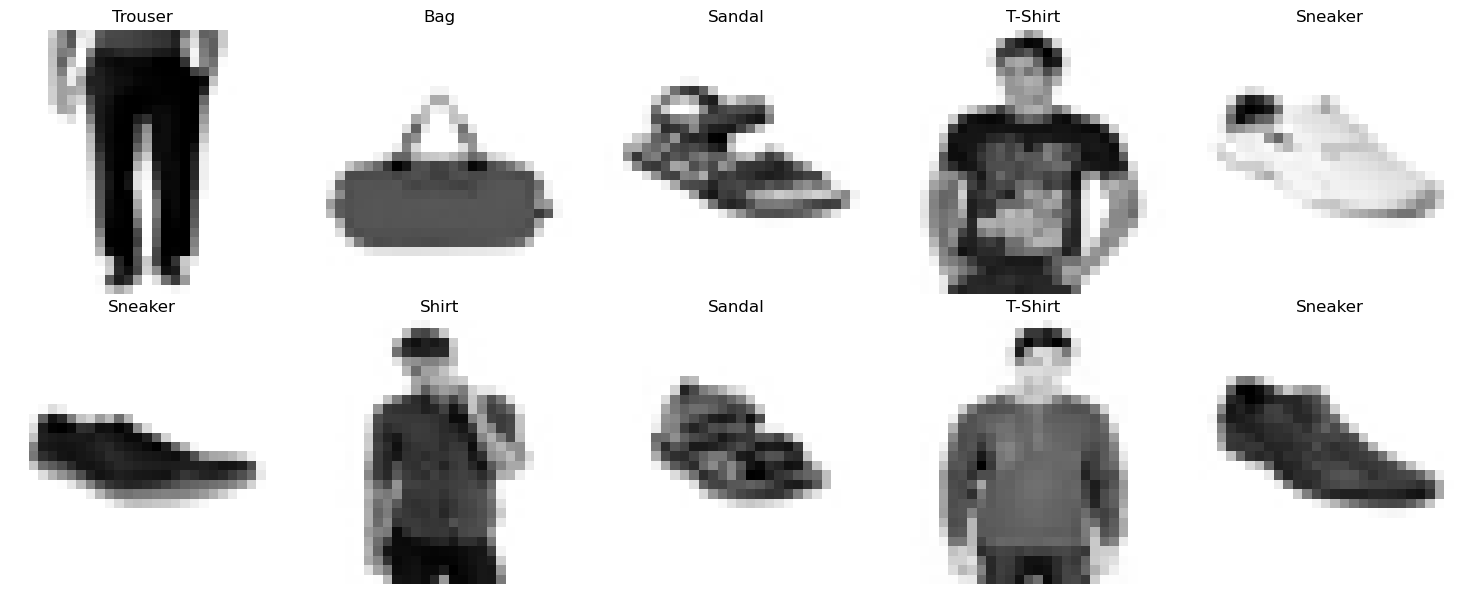

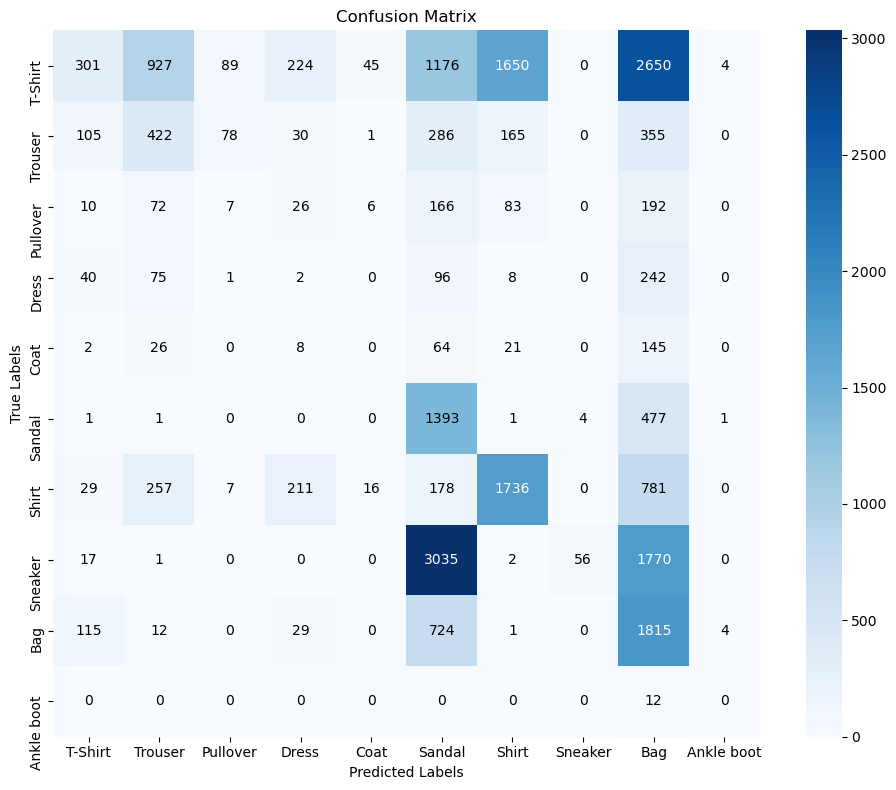

In [162]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# Display image and label.
newdata_features, newdata_labels = next(iter(dataloader_newdata))

# Set the number of images you want to display
num_images = 10

# Create a figure with subplots in a 2 row by 5 column configuration
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i in range(num_images):
    img = newdata_features[i].squeeze()  # Squeeze to remove single-dimensional entries from the shape
    label = newdata_labels[i]
    ax = axes[i]
    ax.imshow(img, cmap="gray")
    # Set the title for each image with its label
    ax.set_title(f"{labels_map[int(label)]}")
    ax.axis('off')  # Hide the axes ticks

plt.tight_layout()
plt.show()

cm = generate_confusion_matrix(model_dropout, dataloader_newdata, labels_map)
